In [1]:
import os
import json

import numpy as np

from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
from src.jump import Jump
from pso import *

In [3]:
BEG_OF_TIME = '2016-06-01'
END_OF_TIME = '2020-09-30'

PSO_HP = PSOHyperparameters(
    inertia = 0.09,
    inertia_dampening = 0.99,
    cognitive_acceleration = 1.0,
    social_acceleration = 1.0,
)

PSO_POPULATION = 100
PSO_NB_ITER    = 100

In [4]:
def get_asset_returns(asset):
    """
    get complete return time serie for an asset
    """
    returns = []

    prev_date = datetime.strptime(BEG_OF_TIME, '%Y-%m-%d').date() - timedelta(days=1)
    prev_value = 0.0

    for i, values in enumerate(asset["values"]):
        current_date = datetime.strptime(values["date"], '%Y-%m-%d').date()

        nb_days = (current_date - prev_date).days
        diff = (values["return"] - prev_value) / nb_days

        for i in range(nb_days - 1):
            returns.append(prev_value)
        returns.append(values["return"])

        prev_value = values["return"]
        prev_date = current_date

    return returns

In [5]:
def plot_history(history):
    plt.plot(history)
    plt.ylabel('fitness')
    plt.xlabel('iteration')
    plt.title('Evolution of fitnesss')
    plt.show()

In [6]:
def check_constraints(best_particle, nb_funds):
    stock_perc = np.sum(best_particle[nb_funds:])

    nav_ok = np.all(np.logical_and(
        np.logical_or(best_particle == 0, best_particle >= 0.01),
        best_particle < 0.1,
    ))

    nb_assets = np.sum(best_particle >= 0.01)

    print(f"[{'OK' if stock_perc > 0.5 else 'KO'}] Stock %: {stock_perc:.2f}")
    print(f"[{'OK' if nav_ok else 'KO'}] %Nav")
    print(f"[{'OK' if nb_assets > 15 else 'KO'}] Asset count: {nb_assets}")

## Preprocessing

### Load assets & get returns time series

In [7]:
asset_dict, portfolio_id = Jump().get_all_assets("assets_cache.json")

keys = list(asset_dict.keys())
assets = list(asset_dict.values())

returns_list = []

for _, asset in asset_dict.items():
    returns = get_asset_returns(asset)
    returns_list.append(returns)

returns_list = np.array(returns_list)

### Split funds and stocks

In [8]:
funds_keys = []
stock_keys = []

funds_returns = []
stock_returns = []

funds_real_count = []
funds_price = []
stock_price = []

#FIXME: there is also one asset with type PORTFOLIO. What to do with it?
for i, (k, v) in enumerate(asset_dict.items()):
    if v["type"] in ("ETF FUND", "FUND", "INDEX"):
        funds_keys.append(k)
        funds_returns.append(returns_list[i])
        # FIXME we should probably take first close ?
        funds_price.append(v['last_close_usd'])
        funds_real_count.append(1)

        # FIXME funds decimalisation: need to divide price and count

    elif v["type"] in ("STOCK",):
        stock_keys.append(k)
        stock_returns.append(returns_list[i])

        # FIXME we should probably take first close ?
        stock_price.append(v['last_close_usd'])

len(funds_keys), len(stock_keys)

(137, 341)

### Get values for PSO

In [9]:
funds_covariance = np.cov(funds_returns)
stock_covariance = np.cov(stock_returns)

funds_values = np.mean(funds_returns, axis=1)
stock_values = np.mean(stock_returns, axis=1)

## Run PSO for stocks

In [10]:
StockPSO = ParticleSwarmOptimizer(
    population_size=PSO_POPULATION,
    hyperparameters=PSO_HP,
    constraints=PSOConstraints(
        n_var = len(stock_values),
        var_min = 0.02,
        var_max = 0.20,
        min_diff_titles = 8,
    ),
    values=stock_values,
    covariance_matrix=stock_covariance,
)

In [11]:
best_stock_particle, history = StockPSO.run(PSO_NB_ITER)

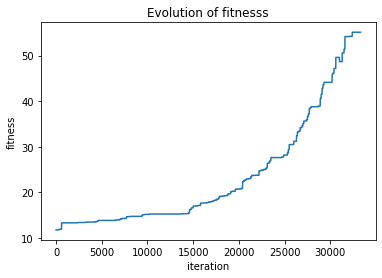

In [12]:
plot_history(history)

## Run PSO for funds

In [13]:
FundsPSO = ParticleSwarmOptimizer(
    population_size=PSO_POPULATION,
    hyperparameters=PSO_HP,
    constraints=PSOConstraints(
        n_var = len(funds_values),
        var_min = 0.02,
        var_max = 0.20,
        min_diff_titles = 8,
    ),
    values=funds_values,
    covariance_matrix=funds_covariance,
)

In [14]:
best_funds_particle, history = FundsPSO.run(PSO_NB_ITER)

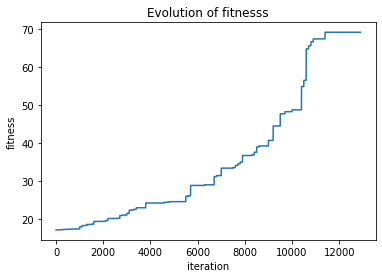

In [15]:
plot_history(history)

# Construct complete portfolio

In [16]:
returns = np.concatenate((funds_returns, stock_returns))
values = np.mean(returns, axis=1)
covariance = np.cov(returns)
prices = np.concatenate((funds_price, stock_price))
real_counts = np.concatenate((funds_real_count, np.ones(len(stock_price))))

best_particle = np.concatenate((best_funds_particle*0.49, best_stock_particle*0.51))

#### Check if constraints are respected

In [17]:
check_constraints(best_particle, len(funds_returns))

[OK] Stock %: 0.51
[OK] %Nav
[OK] Asset count: 18


### Compute total fitness

In [18]:
TestPSO = ParticleSwarmOptimizer(
    population_size=0,
    hyperparameters=PSO_HP,
    constraints=PSOConstraints(
        n_var = len(returns),
        var_min = 0.02,
        var_max = 0.20,
        min_diff_titles = 8,
    ),
    values=values,
    covariance_matrix=covariance,
)
TestPSO.fitness(best_particle)

95.29992859867428

# Compute final portfolio

In [19]:
np.max(funds_price), np.max(stock_price)

(344760.82638447924, 7823.328091298724)

In [20]:
def nav_to_count(total, prices, nav):
    return ((total * nav) / prices).astype(np.int32)

def count_to_nav(total, prices, count):
    return (count * prices) / total

def price_error(total, prices, nav):
    diff = nav - count_to_nav(total, prices, nav_to_count(total, prices, nav))
    return np.sum(np.abs(diff))

total_price = 100000

while price_error(total_price, prices, best_particle) > 0.001:
    total_price *= 2

portfolio_titles = nav_to_count(total_price, prices, best_particle).astype(np.int32)
f"{total_price:,}$"

'102,400,000$'

### Let's check if the approximation was successful

In [21]:
final_particle = count_to_nav(total_price, prices, portfolio_titles)
np.max(np.abs(final_particle - best_particle))

0.0005283250060120204

In [22]:
TestPSO.fitness(final_particle)

95.33528340839044

In [23]:
check_constraints(final_particle, len(funds_returns))

[OK] Stock %: 0.51
[OK] %Nav
[OK] Asset count: 18


### Compute real portfolio

In [24]:
# funds decimalisation
final_portfolio_counts = portfolio_titles * real_counts

# back to IDs!
final_portfolio = {}
keys = np.concatenate((funds_keys, stock_keys))

for i, v in enumerate(final_portfolio_counts):
    if v == 0:
        continue

    final_portfolio[keys[i]] = v

final_portfolio

{'2130': 347363.0,
 '2164': 120885.0,
 '1500': 4852.0,
 '1519': 23460.0,
 '1538': 64626.0,
 '2190': 31233.0,
 '1597': 246.0,
 '1732': 65.0,
 '1745': 28956.0,
 '2066': 23766.0,
 '1475': 249957.0,
 '2004': 687922.0,
 '2024': 894.0,
 '1571': 36973.0,
 '1577': 413904.0,
 '1595': 15408.0,
 '2115': 44175.0,
 '1772': 87931.0}

# Upload portfolio